In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import pyowm
import time
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, RationalQuadratic, ConstantKernel as C
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
import CustomKernels
from CustomDistances import sq_distance, hv_distance
from matplotlib.patches import Path, PathPatch


def format_for_learning(xlat, xlon, temp):
    
    X = np.asarray([[0.0]*2 for i in range(len(xlat))])
    k=0
    for i, j in zip(xlat, xlon):
        X[k][0]=i
        X[k][1]=j
        k+=1
    
    y = np.asarray([0.0 for i in range(len(temp))])
    k=0
    for t in temp:
        y[k] = t
        k+=1
        
    return X, y


def format_grid_for_prediction(ylat, ylon):
    
    grid = np.asarray([[0.0]*2 for i in range(len(ylat)*len(ylon))])
    k=0
    k1=0
    k2=0
    for rlat in ylat:
        k2=0
        for rlon in ylon:
            grid[k][0] = rlat[k1]
            grid[k][1] = rlon[k2]
            k2+=1
            k+=1
        k1+=1
        
    return grid


def format_prediction_to_grid(prediction, nrow, ncol):
    
    matrix = np.empty([ncol, nrow])
    k1=0
    k2=0
    for i in range(nrow):
        for j in range(ncol):
            matrix[i][j] = preds[k1]
            k1 += 1
        
    return matrix
    
    
#Nearest neighbor with plane euclidian distance
def NNI_temp(X, y, grid):
    
    nsample = X.shape[0]
    npreds = grid.shape[0]
    prediction = np.empty(npreds)
    for k in range(0, npreds):
        distance_to_closest = 0
        idx_closest = -1
        distance = 0
        for it in range(0, nsample):
            distance = hv_distance(grid[k][0], grid[k][1], X[it][0], X[it][1])
            if (idx_closest < 0):
                distance_to_closest = distance
                idx_closest = it
            elif (distance_to_closest > distance):
                distance_to_closest = distance
                idx_closest = it
        prediction[k] = y[idx_closest]
            
    return prediction
            
            
#Inverse distance weighting
#Param: radius of the IDW, if no points in the radius -> NNI 
def IDW_temp(X, y, grid, radius):
    
    nsample = X.shape[0]
    npreds = grid.shape[0]
    prediction = np.empty(npreds)
    for k in range(0, npreds):
        numerator = 0
        denominator = 0
        idx_closest = -1
        distance = 0
        distance_to_closest = 0
        for it in range(0, nsample):
            distance = hv_distance(grid[k][0], grid[k][1], X[it][0], X[it][1])
            if (idx_closest < 0):
                distance_to_closest = distance
                idx_closest = it
            elif (distance_to_closest > distance):
                distance_to_closest = distance
                idx_closest = it
            if (distance < radius):
                numerator += y[it]/distance
                denominator += 1/distance
        if (denominator == 0):
            prediction[k] = y[idx_closest]
        else:
            prediction[k] = numerator/denominator
            
    return prediction
        
        
def gaussprocess_temp(X, y, grid):
    
    kernel = C(1.0)*RBF(length_scale=[10.0, 10.0]) + WhiteKernel(0.1)
    #gpr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=True, random_state=0).fit(X, y)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer=None, n_restarts_optimizer=10, normalize_y=True, random_state=0).fit(X, y)
    print("score: %f" % gpr.score(X, y))
    preds = gpr.predict(grid)
    print(gpr.kernel_)
    
    return preds


def GWR_temp(X, y, grid):
    
    kernel = C(1.0)*CustomKernels.RBF(length_scale=100.0, metric='haversine') + WhiteKernel(0.1)
    #gwr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=True, random_state=0).fit(X, y)
    gwr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer=None, n_restarts_optimizer=0, normalize_y=True, random_state=0).fit(X, y)
    print("score: %f" % gpr.score(X, y))
    preds = gpr.predict(grid)
    print(gpr.kernel_)
    
    return preds
    

def regressiontree_temp(X, y, grid, max_depth):
    
    rtree = DecisionTreeRegressor(max_depth=max_depth).fit(X, y)
    preds = rtree.predict(grid)
    
    return preds


def randomforest_temp(X, y, grid, max_ntree, max_depth, random_state):
    
    rforest = RandomForestRegressor(n_estimators=max_ntree, max_features='auto', 
                                    max_depth=max_depth, random_state=random_state).fit(X, y)
    preds = rforest.predict(grid)
    
    return preds


def extratrees_temp(X, y, grid, max_ntree, max_depth, random_state):
    
    extrees = ExtraTreesRegressor(n_estimators=max_ntree, max_features='auto', 
                                    max_depth=max_depth, random_state=random_state).fit(X, y)
    preds = extrees.predict(grid)
    
    return preds

def SVR_temp(X, y, grid):
    
    svr = SVR(gamma='auto', C=10.0, epsilon=5.0).fit(X, y)
    preds = svr.predict(grid)
    
    return preds


In [2]:
#Read cities list
obs = pd.read_csv("data/current-version/Temp-2019_01_04-15_47.csv", ',')
obs = obs.drop(['Unnamed: 0'], axis=1)

#Get cities coordinates and ID
nam = obs['City'].tolist()
lon = obs['Lon'].tolist()
lat = obs['Lat'].tolist()
ids = obs['ID'].tolist()
temps = obs['Temp'].tolist()

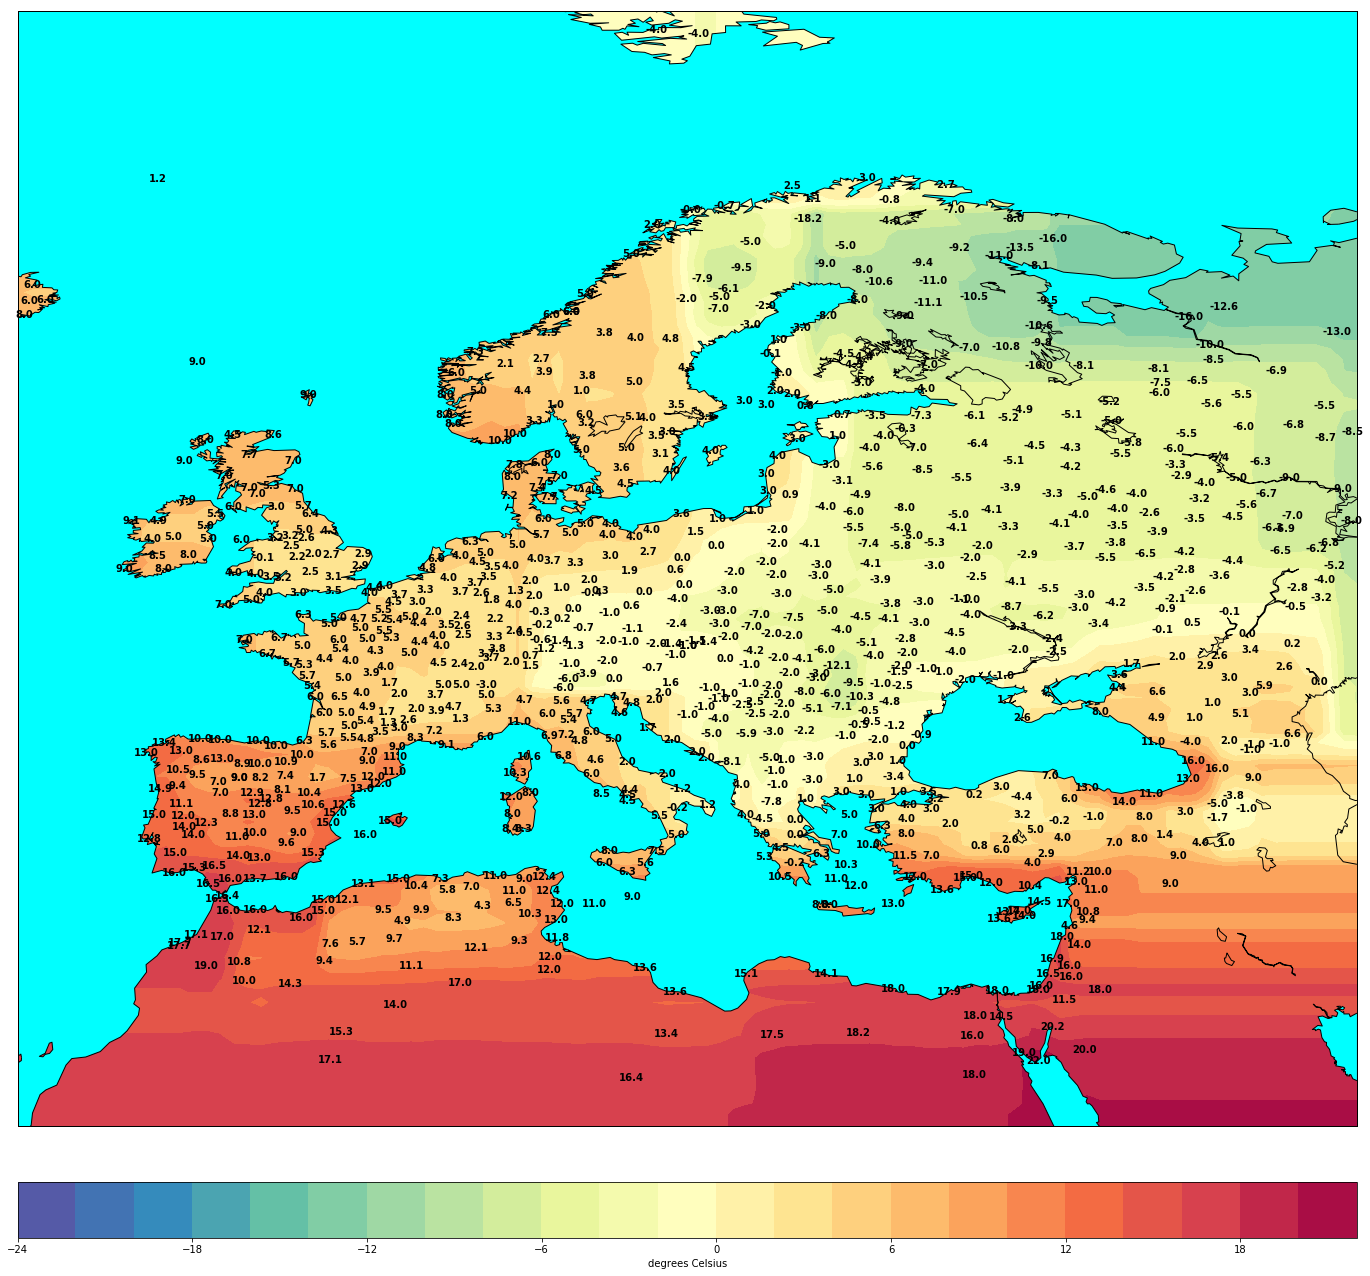

In [3]:
#Map boundaries
lon_min = -15.56
lat_min = 24.65
lon_max = 49.88
lat_max = 79.17

#Interpolation resolution
nx = 100
ny = 100

cities_out_bounds = []

#Create map
fig, ax = plt.subplots(figsize=(24,24))
map = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max, resolution = 'l', epsg=4668)
map.drawmapboundary(fill_color='white')
#map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()

x, y = map(lon, lat)

#Create annotations for temperature and only keep cities in bound
for i in range(0,len(x)-1):
    if lon[i] > lon_min and lon[i] < lon_max and lat[i] > lat_min and lat[i] < lat_max:
        plt.text(x[i], y[i], "{0:.1f}".format(temps[i]),fontsize=10,fontweight='bold', ha='center',va='center',color='k')
    else:
        cities_out_bounds.append(nam[i])

glons, glats = map.makegrid(nx, ny)
gx, gy = map(glons, glats)
predict = np.zeros((nx, ny))

#Format data for interpolation
X_learn, y_learn = format_for_learning(lat, lon, temps)
grid = format_grid_for_prediction(glats, glons)

#Choose the interpolation model
#preds = NNI_temp(X_learn, y_learn, grid)
#preds = IDW_temp(X_learn, y_learn, grid, 500)
#preds = gaussprocess_temp(X_learn, y_learn, grid)
#preds = GWR_temp(X_learn, y_learn, grid)
#preds = regressiontree_temp(X_learn, y_learn, grid, 10)
preds = randomforest_temp(X_learn, y_learn, grid, max_ntree=1000, max_depth=10, random_state=69)
#preds = extratrees_temp(X_learn, y_learn, grid, max_ntree=1000, max_depth=10, random_state=69)
#preds = SVR_temp(X_learn, y_learn, grid)

#Format the predictions for plotting
predict = format_prediction_to_grid(preds, nx, ny)

#Plot contours
clevs = [-24,-22,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22]
cs = map.contourf(gx,gy,predict,clevs,cmap='Spectral_r')

#Display colorbar
cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('degrees Celsius')

##getting the limits of the map:
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in map.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='cyan', lw=0)

##masking the data:
ax.add_patch(patch)
